In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [2]:
# Define the paths to training and testing directories
train_dir = r"train_path"
test_dir = r"test_path"

# Define the target classes
target_classes = ['happy', 'sad', 'surprise', 'neutral']

# Create ImageDataGenerator for training data with augmentation and RGB conversion
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,        # Randomly rotate images in the range (degrees)
    width_shift_range=0.3,    # Randomly translate images horizontally
    height_shift_range=0.3,   # Randomly translate images vertically
    shear_range=0.2,          # Randomly shear images
    zoom_range=0.2,           # Randomly zoom in and out on images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest',      # Fill in missing pixels after transformations
    brightness_range=[0.7, 1.4] # Randomly change brightness range
)

# Filter the training data to include only the target classes
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=128,
    class_mode='categorical',
    classes=target_classes,
    shuffle=True
)

# Create ImageDataGenerator for validation data with RGB conversion
validation_datagen = ImageDataGenerator(rescale=1./255)

# Filter the validation data to include only the target classes
validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=128,
    class_mode='categorical',
    classes=target_classes,
    shuffle=False
)

Found 20181 images belonging to 4 classes.
Found 5085 images belonging to 4 classes.


In [3]:
# Load VGG16 model with pre-trained ImageNet weights, without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the first 6 layers
for layer in base_model.layers[:6]:
    layer.trainable = False

# Build the custom model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(256, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

In [4]:
# Set up the ReduceLROnPlateau callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=1e-7
)

# Set up EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Set up ModelCheckpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [5]:
# Train the model with both learning rate reduction and early stopping
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction, early_stopping, checkpoint]
)

Epoch 1/30
158/158 [==============================] - 202s 1s/step - loss: 1.4880 - accuracy: 0.4290 - val_loss: 1.2806 - val_accuracy: 0.5681

Epoch 00001: val_accuracy improved from -inf to 0.56814, saving model to model.h5
Epoch 2/30
158/158 [==============================] - 129s 814ms/step - loss: 1.0822 - accuracy: 0.6068 - val_loss: 1.0966 - val_accuracy: 0.6246

Epoch 00002: val_accuracy improved from 0.56814 to 0.62458, saving model to model.h5
Epoch 3/30
158/158 [==============================] - 126s 796ms/step - loss: 0.9677 - accuracy: 0.6532 - val_loss: 0.8505 - val_accuracy: 0.7062

Epoch 00003: val_accuracy improved from 0.62458 to 0.70619, saving model to model.h5
Epoch 4/30
158/158 [==============================] - 128s 806ms/step - loss: 0.9058 - accuracy: 0.6808 - val_loss: 0.9677 - val_accuracy: 0.6671

Epoch 00004: val_accuracy did not improve from 0.70619
Epoch 5/30
158/158 [==============================] - 130s 819ms/step - loss: 0.8630 - accuracy: 0.6999 - va

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get class names from the validation generator
class_names = list(validation_generator.class_indices.keys())

# Get the true labels and predictions
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=-1)

# Classification report with class names
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       happy       0.91      0.89      0.90      1774
         sad       0.69      0.76      0.72      1247
    surprise       0.86      0.86      0.86       831
     neutral       0.72      0.67      0.69      1233

    accuracy                           0.80      5085
   macro avg       0.79      0.79      0.79      5085
weighted avg       0.80      0.80      0.80      5085



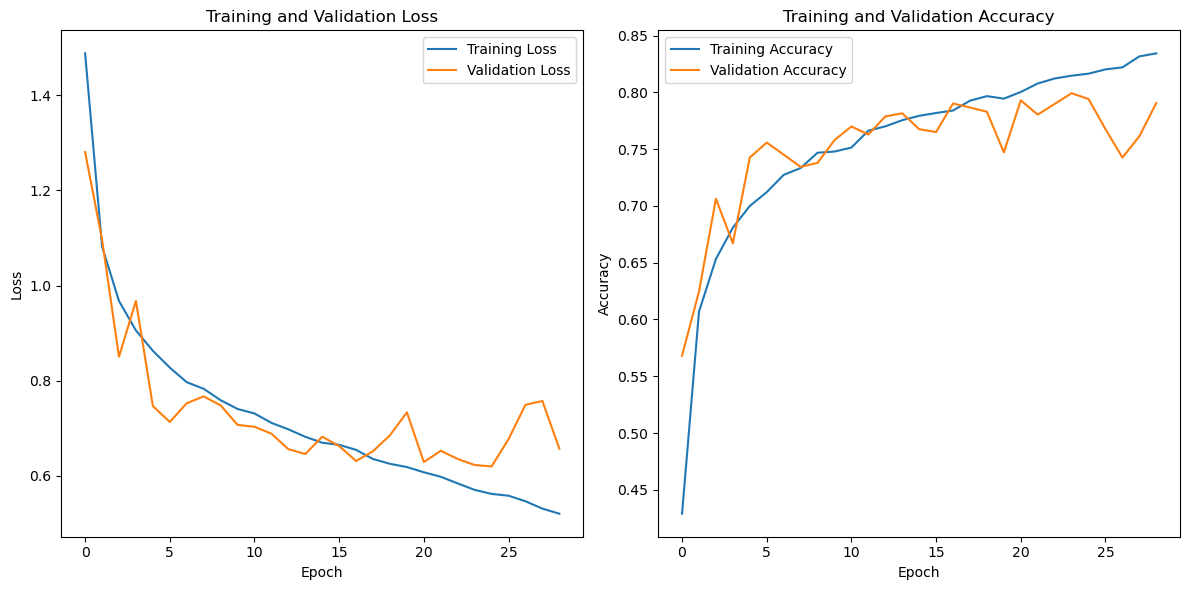

In [7]:
import matplotlib.pyplot as plt

# Plotting Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()